In [131]:
!pip install pretrainedmodels

In [132]:
!curl -O http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   278  100   278    0     0    358      0 --:--:-- --:--:-- --:--:--   357


In [133]:
!pip install imutils

In [134]:
import matplotlib.pyplot as plt
import matplotlib
import argparse 
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import pickle
import random
import pretrainedmodels
import torchvision

matplotlib.style.use('ggplot')

from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm

<div id="1"></div>
# 1 数据集简介

Caltech-101数据集大小为132MB，包含101类物体图片，和1个杂乱类（background），数据集中已经标注了图像所属的类别，主要用于目标识别和图像分类。

本案例中，不采用杂乱类，采用其余101类物体图片进行训练。总共包含8677幅图像，其中每个类别包含不同角度、背景、光照下获得的40到800张图像，每张图像的大小为 300 $\times $200 像素。


首先读取Caltech-101数据集。并对数据集进行处理，主要提取出数据集中的图像及其对应的类别，并对应保存在变量中。

In [139]:
import tarfile
with tarfile.open('/content/101_ObjectCategories.tar.gz', 'r:gz') as tar:
  tar.extractall()

In [164]:
image_paths = list(paths.list_images('/content/drive/My Drive/101_ObjectCategories'))

data = []
labels = []
label_names = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]

    # 删去杂乱类
    if label == 'BACKGROUND_Google':
        continue

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    data.append(image)
    label_names.append(label)
    labels.append(label)

data = np.array(data)
labels = np.array(labels)

# 图像的类别
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print("数据集共有",len(lb.classes_),"类")

# 储存图像类别的名称
count_arr = []
label_arr = []
for i in range(len(lb.classes_)):
    count = 0
    for j in range(len(label_names)):
        if lb.classes_[i] in label_names[j]:
            count += 1
    count_arr.append(count)
    label_arr.append(lb.classes_[i])

数据集共有 101 类


下图为101类中，每个类别包含的图片数量。我们可以直观感受到，数据集存在两个问题： 

（1）数据集不平衡。人脸数据集包含的图像最多，约900张，而很多数据集只包含40张左右的图像。

（2）数据集较小。从图中可以看到，很多类别包含的图像数量很少，只有40-100张左右。



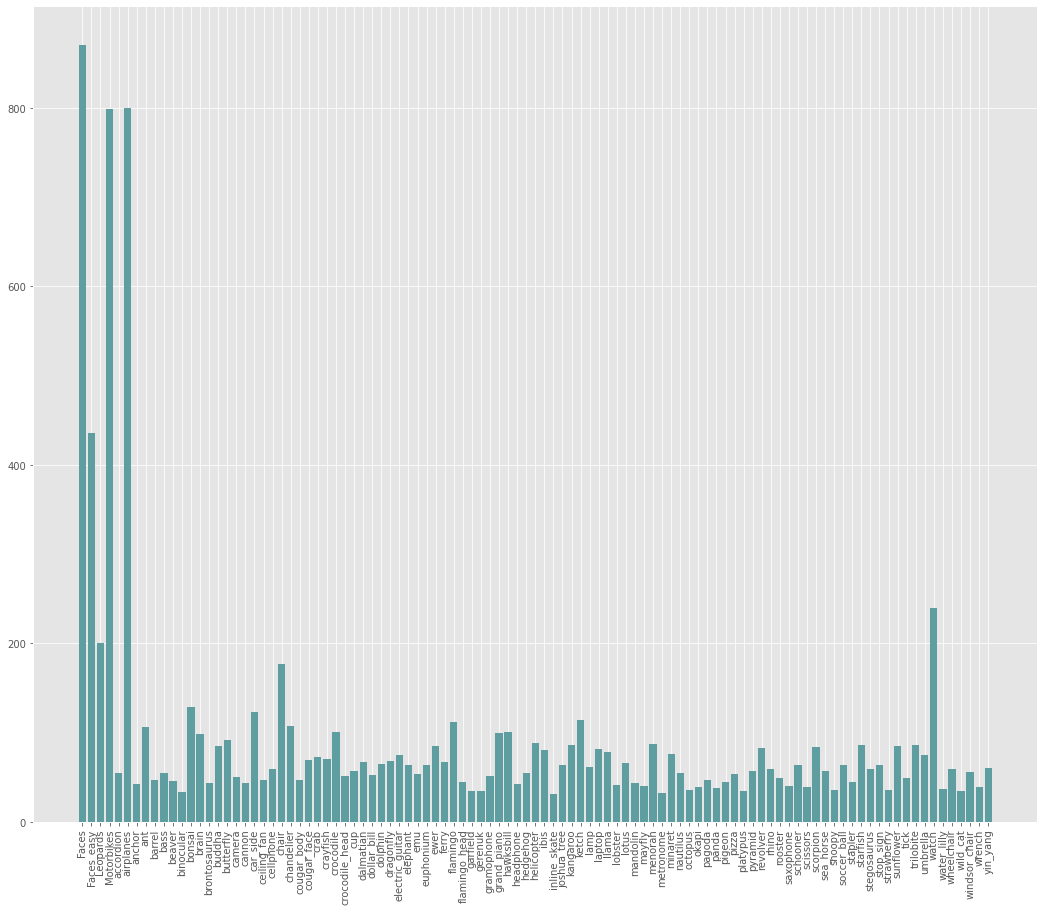

In [141]:
plt.figure(figsize=(18, 15))
plt.bar(label_arr, count_arr,color="cadetblue")
plt.xticks(rotation='vertical')
plt.show()

数据集不平衡和数据集小可能造成神经网络训练结果不理想。

本案例中使用微调和迁移学习，克服数据集不平衡的问题，达到95%的分类准确率。解决数据集不平衡的常用方法，还有使用图像增强增加图片的数量，感兴趣的读者可以进行尝试。

1.2 划分训练集、验证集和测试集

接下来，我们调用sklearn库中的train_test_split函数，来划分数据集。划分比例为，训练集：验证集：测试集 = 3:1:1。

In [165]:
(X, x_val , Y, y_val) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)

(x_train, x_test, y_train, y_test) = train_test_split(X, Y, 
                                                    test_size=0.25, 
                                                    random_state=42)

print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}\nx_val examples: {x_val.shape}")

x_train examples: (5205,)
x_test examples: (1736,)
x_val examples: (1736,)


模型训练中，图像的格式需要一致，因此我们定义图像格式转换函数，将图像调整为224*224像素，并将原数据格式转换为tensor形式，并对其进行标准化。标准化图像所需的参数，来源于在ImageNet上预训练得到的参数。

下列代码进行了上述的格式转换，这里我们分开定义训练集和验证集。这样当我们想对训练集和验证集进行不同的操作时，更加方便明了。

In [166]:
# 定义格式转换函数
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
	 transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

接下来我们调用刚才定义的格式转换函数，将训练集、验证集、测试集都进行格式转换，并保存下来，在训练模型的时候调用。

In [167]:
# 转换并保存训练集、验证集、测试集
class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data
 
train_data = ImageDataset(x_train, y_train, train_transform)
val_data = ImageDataset(x_val, y_val, val_transform)
test_data = ImageDataset(x_test, y_test, val_transform)
 
# 数据集 dataloaders
trainloader = DataLoader(train_data, batch_size=16, shuffle=True)
valloader = DataLoader(val_data, batch_size=16, shuffle=True)
testloader = DataLoader(test_data, batch_size=16, shuffle=False)

划分好数据集后，我们通过图像随机抽取出现有的训练集，观察图像，并确认其大小一致。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


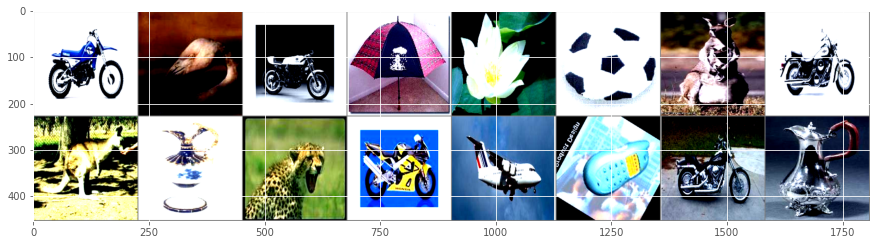

In [168]:
def imshow(img):
    plt.figure(figsize=(15, 12))
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    plt.show()

# 随机获取一些图像
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图像
imshow(torchvision.utils.make_grid(images))

本小节，我们将构建ResNet网络。


首先设置随机种子，以便读者在运行时能够获得与本文一致的运行结果，便于理解文中对运行结果的分析。

In [169]:
# 定义随机种子

def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED']=str(SEED)
    torch.backends.cudnn.benchmark = False # as all the inputs are not of same size
SEED=42
seed_everything(SEED=SEED)


相比于CPU，使用GPU训练模型，能够大大减少训练时间，下列代码能够让程序调用GPU训练模型。

In [170]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

epoch指对所有样本进行训练的次数，batch_size指一次一起训练的样本的数量。考虑到运行时间和内存大小，本案例中进行如下定义。

In [171]:
epochs = 5
BATCH_SIZE = 16

接下来构建ResNet的网络结构。
构建ResNet网络。

为了减少模型的训练时间，以及考虑到数据集较少，可能会影响训练结果，我们使用在ImageNet上训练后得到的参数，在Caltech101数据集上训练，进行微调，得到训练结果。

因为神经网络在提取特征时，前面的层所提取的特征更具一般性，后面的层则更加具体，更具有原始数据集的特征。因此考虑到Caltech101数据集较小，且与ImageNet的相似程度不高，我们微调ResNet较前面的层。

除了进行微调以外，我们还加入Dropout层，避免模型过拟合。

In [172]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
    # 调用在ImagetNet上预训练的ResNet模型的权重
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained='imagenet')
        else:
            self.model = pretrainedmodels.__dict__['resnet34'](pretrained=None)
        
        # 改变全连接层的输出
        self.l0 = nn.Linear(512, len(lb.classes_))
        # 设置dropout层的参数
        self.dropout = nn.Dropout2d(0.4)
    
    # 对在ImageNet上训练得到的ResNet模型进行微调
    def forward(self, x):
        # 得到图像数据
        batch, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        # 在全连接层前接入Dropout层
        x = self.dropout(x)
        # 连接全连接层
        l0 = self.l0(x)
        return l0

# 显示模型构造
model = ResNet34(pretrained=True).to(device)
print(model)

# 定义优化参数的方法
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# 定义损失函数
criterion = nn.CrossEntropyLoss()

ResNet34(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

定义了ResNet模型构造后，接下来需要定义训练模型和验证模型的函数。

首先定义训练模型的函数，函数需要实现计算分类准确率、损失值、通过反向传播优化参数等功能。

In [173]:
# 训练函数
def fit(model, dataloader):
    print('训练')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    # 对每个批次（batch）进行训练
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        
        # 梯度值更新为零
        optimizer.zero_grad()
        outputs = model(data)

        # 计算损失值
        loss = criterion(outputs, torch.max(target, 1)[1])
        train_running_loss += loss.item()
        
        # 得到分类结果
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        # 通过反向传播更新参数
        loss.backward()
        optimizer.step()
    
    # 每次训练完所有数据（一次epoch）后，计算损失值和分类准确率
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)
    
    print(f"训练集 损失值: {train_loss:.4f}, 训练集 准确率: {train_accuracy:.2f}")
    
    return train_loss, train_accuracy

接下来我们定义验证函数。验证函数与训练函数的构造类似，不同点在于，在验证函数中，我们不需要更新参数，因此不需要进行反向传播等步骤。

In [174]:
# 验证函数
def validate(model, dataloader):
    print('验证')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)
        print(f'验证集 损失值: {val_loss:.4f}, 验证集 准确率: {val_accuracy:.2f}')
        
        return val_loss, val_accuracy



训练模型

在定义好上述函数后，我们调用这些函数，在Caltech-101数据集上进行模型的训练。

In [175]:
print(f"训练集包含 {len(train_data)} 张图像，验证集包含 {len(val_data)} 张图像")

# 训练模型
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    # 调用训练函数和验证函数
    train_epoch_loss, train_epoch_accuracy = fit(model, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(model, valloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()

# 显示训练模型需要的时间
print((end-start)/60, 'minutes')

  0%|          | 1/325 [00:00<00:44,  7.29it/s]

训练集包含 5205 张图像，验证集包含 1736 张图像
Epoch 1 of 5
训练


326it [00:33,  9.82it/s]                         
  2%|▏         | 2/108 [00:00<00:06, 16.32it/s]

训练集 损失值: 0.1028, 训练集 准确率: 68.11
验证


109it [00:06, 15.66it/s]                         
  1%|          | 2/325 [00:00<00:32, 10.09it/s]

验证集 损失值: 0.0253, 验证集 准确率: 92.28
Epoch 2 of 5
训练


326it [00:33,  9.84it/s]                         
  2%|▏         | 2/108 [00:00<00:06, 15.97it/s]

训练集 损失值: 0.0195, 训练集 准确率: 95.20
验证


109it [00:06, 15.64it/s]                         
  0%|          | 0/325 [00:00<?, ?it/s]

验证集 损失值: 0.0129, 验证集 准确率: 95.39
Epoch 3 of 5
训练


326it [00:33,  9.79it/s]                         
  2%|▏         | 2/108 [00:00<00:06, 15.82it/s]

训练集 损失值: 0.0071, 训练集 准确率: 98.42
验证


109it [00:06, 15.75it/s]                         
  0%|          | 1/325 [00:00<00:33,  9.60it/s]

验证集 损失值: 0.0100, 验证集 准确率: 96.03
Epoch 4 of 5
训练


326it [00:33,  9.85it/s]
  2%|▏         | 2/108 [00:00<00:06, 16.02it/s]

训练集 损失值: 0.0046, 训练集 准确率: 98.94
验证


109it [00:06, 15.66it/s]                         
  0%|          | 1/325 [00:00<00:32,  9.99it/s]

验证集 损失值: 0.0123, 验证集 准确率: 94.99
Epoch 5 of 5
训练


326it [00:33,  9.84it/s]                         
  2%|▏         | 2/108 [00:00<00:06, 15.61it/s]

训练集 损失值: 0.0041, 训练集 准确率: 99.00
验证


109it [00:06, 15.75it/s]                         

验证集 损失值: 0.0150, 验证集 准确率: 93.95
3.3434282302856446 minutes


观察输出的结果可以发现，模型的准确率在不断提高，但评价模型的结果，也需要将损失值纳入考虑，避免模型过拟合。

下面我们通过图像，观察模型的分类效果如何。

下图展示了模型在训练集和验证集上，对图像分类的准确率。很明显看到，在进行3个epoch后，模型在训练集上的分类准确率仍在提升，近乎达到100%的准确率。但是模型在验证集上的准确率也有下降的趋势。判断在3个epoch后，模型可能存在过拟合的情况。

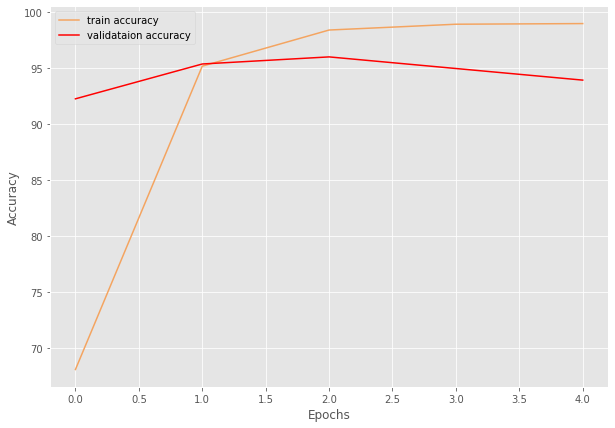

In [176]:
# 分类准确率折线图
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='sandybrown', label='train accuracy')
plt.plot(val_accuracy, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

再观察模型在训练集和验证集上的损失值。下图同样表现出，即使模型在训练集上的损失值不断降低，但在3个epoch后，模型在验证集上的损失值有增长的趋势。同样表现出模型存在过拟合的情况。

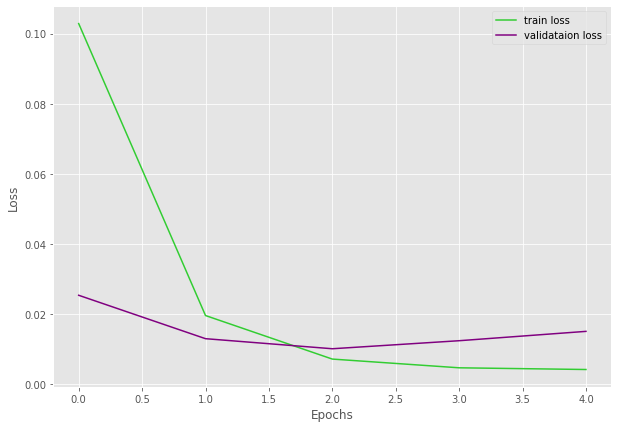

In [177]:
# 损失值折线图
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='limegreen', label='train loss')
plt.plot(val_loss, color='purple', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

最后，我们在测试集上运行模型，结果如下。多次测试后，可以得到结论：我们构造的ResNet模型对Caltech-101数据集的分类结果，可以达到95%左右的准确率。

In [178]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        inputs, target = data[0].to(device, non_blocking=True), data[1].to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == torch.max(target, 1)[1]).sum().item()

print('模型在测试集上的分类准确率 : %0.3f %%' % (
    100 * correct / total))

模型在测试集上的分类准确率 : 94.412 %
